In [137]:
from strategic1 import best_response
from data_prep import load_data
from optimization1 import evaluate_loss, logistic_regression

import numpy as np


In [154]:
# load data
np.random.seed(0) 
X, Y, data = load_data('path')
n = X.shape[0]
d = X.shape[1]
print(n,d-1)


18357 10


In [155]:
strat_features = np.array([1, 6, 8]) - 1

print('Strategic Features: \n')
for i, feature in enumerate(strat_features):
    print(i, data.columns[feature + 1])

Strategic Features: 

0 RevolvingUtilizationOfUnsecuredLines
1 NumberOfOpenCreditLinesAndLoans
2 NumberRealEstateLoansOrLines


In [ ]:
# S :strategic_feature_chose_matrix
# X(z)= strategic_eps * (1_n z^T) S + X_origin
# W_1(D(z),D(z’)) = \|strategic_eps * 1_n (z-z’)^T S\|_2.   ! z just the selected z
# eps <= strategic_eps * \|S^\| \|z_sel - z_sel'\| / \|z - z'\|
# eps for sensitivity bound       

def check_eps_bound_given_z(z,strategic_eps):
    d = len(z)
    cols = [0, 5, 7] 
    z_sel = z[cols]   
    k = len(cols)
    S = np.zeros((k, d))
    for i, j in enumerate(cols):
        S[i, j] = 1.0
    # shift = (np.ones((n, 1)) @ z_sel.reshape(1, -1)) @ S
    # X1 = X - strategic_eps * shift
    # equivalent to best_response(X, z, strategic_eps,strat_features)

    sel_gap = np.linalg.norm(z_sel)
    norm_gap =  np.linalg.norm(z) 
    eps_bound = strategic_eps * np.linalg.norm(S) *  abs(sel_gap/norm_gap)
    return eps_bound



In [157]:
num_iters    = 4000
lam = 30.0/n # strongly convexity
strategic_eps_list = [0.01, 1, 100]
num_eps = len(strategic_eps_list)


In [ ]:
# train until early stop to treat it as truth
z = np.random.randn(d)
patience = 10 
no_improve = 0
best_loss = np.inf
best_idx = -1
true_z_list =[]
true_loss_list =[]
num_iters_max = 10000
for t in range(num_iters_max):        
    # gradient descent
    z_new, ll, logistic_smoothness = logistic_regression(X, Y, lam, z_init=z)
    true_loss_list.append(ll)
    true_z_list.append(np.copy(z_new))
         
    z = np.copy(z_new)

    # early_stop: if loss keep exceed the min over 10 times, then stop
    curr_idx = len(true_loss_list) - 1
    if ll < best_loss :
        best_loss = ll
        best_idx = curr_idx
        no_improve = 0
    else:
        no_improve += 1
        if no_improve >= patience:
            print(f"Early stop at iteration {t} (no improvement for {patience} steps).")

            # Trim all lists to best_idx+1 to remove the trailing 
            keep = best_idx + 1 if best_idx >= 0 else 0
            true_loss_list     = true_loss_list[:keep]
            true_z_list        = true_z_list[:keep]

            # restore z to the best one
            if keep > 0:
                z = np.copy(true_z_list[-1])
            break
z_best = true_z_list[-1]
print("loss:", best_loss)


loss: 0.614262596124071


In [159]:
z_list      = [[] for _ in range(num_eps)]
z_gaps         = [[] for _ in range(num_eps)]
loss_list            = [[] for _ in range(num_eps)]

lp_list_start      = [[] for _ in range(num_eps)]
lp_list_end        = [[] for _ in range(num_eps)]
k_list = [[] for _ in range(num_eps)] # track k
# dist = [[[] for _ in range(num_eps)] for _ in range(len(strat_features))]
eps_list = []

In [160]:

# train
for c, eps in enumerate(strategic_eps_list):
    n, d = X.shape
    # initial z
    z = np.random.randn(d)
    patience = 10 
    no_improve = 0
    best_loss = np.inf
    best_idx = -1
    print('Running strategic epsilon =  ', eps)
    
    for t in range(num_iters):
        
        # adjust distribution to current theta
        X_strat = best_response(X, z, eps, strat_features)
        
        # evaluate initial loss on the current distribution
        # performative loss value of previous z
        loss_start = evaluate_loss(X_strat, Y, z, lam, strat_features)
        
        lp_list_start[c].append(loss_start)
        
        # gradient descent
        z_new, ll, logistic_smoothness = logistic_regression(X_strat, Y, lam, z_init=z)
                                                                 
        
        loss_list[c].append(ll)
        z_list[c].append(np.copy(z_new))
        
        smoothness = max(logistic_smoothness + lam, 2) # lipschitz gradient
        
        k_list[c].append(smoothness/lam)

        # evaluate final loss on the current distribution
        loss_end = evaluate_loss(X_strat, Y, z_new, lam, strat_features)
        
        lp_list_end[c].append(loss_end)        
        
        z = np.copy(z_new)

        # early_stop: if loss keep exceed the min over 10 times, then stop
        curr_idx = len(loss_list[c]) - 1
        if loss_end < best_loss :
            best_loss = loss_end
            best_idx = curr_idx
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= patience:
                print(f"Early stop at iteration {t} (no improvement for {patience} steps).")

                # Trim ALL lists to best_idx+1 
                keep = best_idx + 1 if best_idx >= 0 else 0
                loss_list[c]     = loss_list[c][:keep]
                z_list[c]        = z_list[c][:keep]
                lp_list_start[c] = lp_list_start[c][:keep]
                lp_list_end[c]   = lp_list_end[c][:keep]
                k_list[c]        = k_list[c][:keep]

                # restore z to the best one
                if keep > 0:
                    z = np.copy(z_list[c][-1])
                break

    k = smoothness / lam
    eps_check_list =[]
    for i,z in enumerate(z_list[c]):
        eps_for_given_z = check_eps_bound_given_z(z,eps)
        eps_check_list.append(eps_for_given_z)
    eps = max(eps_check_list)
    eps_list.append(eps)
    print("current_eps:", eps)
    print(f"current check for convergence garantee (fail if negative): {1 - 2*eps**2 * k} \n")


Running strategic epsilon =   0.01
current_eps: 0.01198013674710565
current check for convergence garantee (fail if negative): 0.18010614666503633 

Running strategic epsilon =   1
current_eps: 0.6648772483346603
current check for convergence garantee (fail if negative): -2525.7282433948294 

Running strategic epsilon =   100
current_eps: 96.47425073907826
current check for convergence garantee (fail if negative): -200035823.38598868 



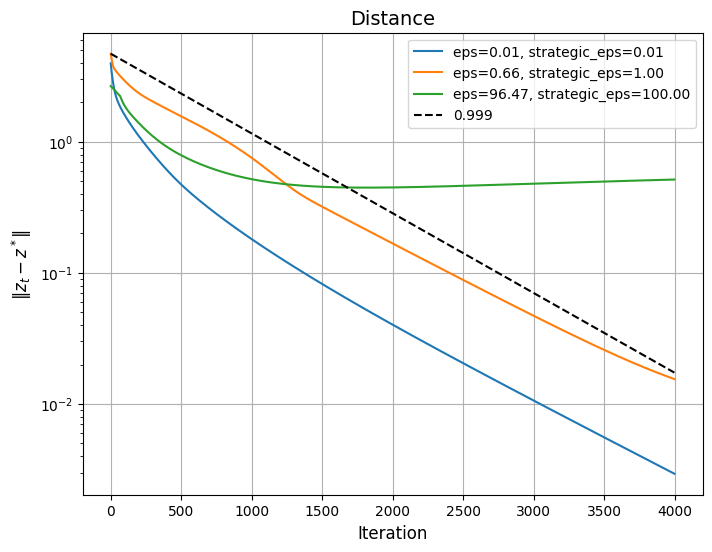

In [161]:
import matplotlib.pyplot as plt
max_start = 0.0
plt.figure(figsize=(8,6))
for c, eps in enumerate(eps_list):
    z_hist = np.array(z_list[c])       
    dists = np.linalg.norm(z_hist - z_best, axis=1) 

    plt.plot(range(len(z_hist)), dists, label=f"eps={eps:.2f}, strategic_eps={strategic_eps_list[c]:.2f}")
    max_start = max(max_start, dists[0]) 

ref = (0.9986) ** np.arange(num_iters)
ref = ref * max_start / ref[0]   # normalize to largest starting dist
plt.plot(range(num_iters), ref, 'k--', label="0.999")

plt.xlabel("Iteration", fontsize=12)
plt.ylabel(r"$\|z_t - z^*\|$", fontsize=12)
plt.title("Distance", fontsize=14)
plt.yscale("log")   
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# LMI check
import numpy as np
import cvxpy as cp


def build_M(n, smoothness, m, eps):
    # multiplier in IQC
    b = smoothness + m
    a = 2*m * smoothness*(1-eps) - (2.0 + 4*eps) * eps * smoothness**2
    I = np.eye(n)
    Z = np.zeros((n, n))
    bI = b * I
    aI = a * I
    M = np.block([
        [-bI,  aI],
        [ aI,  -I]
    ]).astype(float)
    return M

def check_lmi_feasible(n, eta, rho, M, eps_reg=1e-6, solver="SCS", verbose=False):
    """
    Solve: [ (1-rho^2)P,  -P B;
             -B^T P,     B^T P B ] + lambda M  ⪯ 0,
    vars: P (n×n, PD),  lambda ≥ 0.  rho is fixed in (0,1).
    """
    I = np.eye(n)
    B = np.hstack([eta * I])           
 
    # Decision vars
    P   = cp.Variable((n, n), symmetric=True)
    lam = cp.Variable(nonneg=True)

    # Blocks
    TL = (1 - rho**2) * P                  # (n x n)
    TR = - P @ B                           # (n x 2n)
    BL = TR.T                              # (2n x n)
    BR = B.T @ P @ B                       # (2n x 2n)

    LMI = cp.bmat([[TL, TR],
                   [BL, BR]]) + lam * M    # (3n x 3n)

    delta = 0   # tighter if needing LMI < 0
    constr = [P >> eps_reg*np.eye(n),  LMI << -delta*np.eye(2*n)]

    prob = cp.Problem(cp.Minimize(0), constr)
    prob.solve(solver=solver, verbose=verbose)

    status_ok = (prob.status in ("optimal", "optimal_inaccurate"))
    if status_ok:
        # Numerical check: largest eigenvalue should be ≤ 0
        LMI_val = LMI.value
        lam_max = np.linalg.eigvalsh( LMI_val )[ -1 ]
    else:
        lam_max = None

    return status_ok, lam.value if status_ok else None, P.value if status_ok else None, lam_max



In [163]:
n          = d
sample_size = n
m          = lam

for c, eps in enumerate(strategic_eps_list):
    max_k     = max(k_list[c])
    smoothness = m * max_k
    eps        = eps_list[c]
    eta        = 1.0 / (smoothness + 2.0 * m)

    M = build_M(n, smoothness, m, eps)

    rhos = np.linspace(0.01, 0.99, 100)

    smallest_feasible_rho = None
    last_msg = None

    for rho in rhos:
        try:
            ok, lam_star, P_star, lammax = check_lmi_feasible(
                n, eta, rho, M, eps_reg=1e-5, solver="CVXOPT"
            )
        except Exception as e:
            # if the solver error, record and continue trying other rho
            last_msg = f"solver error at rho={rho:.4f}: {e}"
            ok = False
            lam_star, P_star, lammax = None, None, None

        if ok:
            smallest_feasible_rho = rho
            print(
                f"[c={c}] eps={eps} -> smallest feasible rho={rho:.4f}, "
                f"lambda≈{lam_star:.6g} "
                f"{' maxeig(LMI)≈'+str(lammax) if lammax is not None else ''}"
            )
            break

    if smallest_feasible_rho is None:
        note = f" (note: {last_msg})" if last_msg else ""
        print(f"[c={c}] eps={eps} -> not feasible over rho ∈ [0.01, 0.99]{note}")

[c=0] eps=0.01198013674710565 -> smallest feasible rho=0.0100, lambda≈0.5433  maxeig(LMI)≈-0.3443574689997863
[c=1] eps=0.6648772483346603 -> not feasible over rho ∈ [0.01, 0.99]
[c=2] eps=96.47425073907826 -> not feasible over rho ∈ [0.01, 0.99] (note: solver error at rho=0.9900: Solver 'CVXOPT' failed. Try another solver, or solve with verbose=True for more information.)
